In [241]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Inputs will be:

 - Load [MW]
 - Wind Excess [MW]
 - Wind Shortage [MW]
 - Previous State of Charge [MWh]
 - Previous Tank Holdup [kg]
 - Next 4, 8, 12, 16, 24 Hrs Excess
 - Next 4, 8, 12, 16, 24 Hrs Shortage

Outputs will be:

 - Ratio Battery Input to Nameplate [MW]
 - Ratio PEM Input to Nameplate [MW]
 - Ratio Battery Output to Nameplate [MW]
 - Ratio Turbine Output to Nameplate[MW]

In [242]:
import pandas as pd
import os
import json
from pathlib import Path
from dispatches.case_studies.renewables_h2_case.re_h2_parameters import re_h2_parameters, get_gen_outputs_from_rtsgmlc, kg_to_tons, h2_mols_per_kg


results_dir = Path("double_loop_317_CT_batth2")
with open(results_dir / "input_parameters.json", "r") as f:
    params = json.load(f)
year_results = pd.read_csv(results_dir / "design_timeseries_minsocfree.csv")
year_results.drop(columns="Unnamed: 0", inplace=True)
wind_gen = "317_WIND"
wind_gen_pmax = 799.1
gas_gen = "317_CT"
reserves = 15
shortfall = 500
start_date = '2020-01-01 00:00:00'
wind_cfs, wind_resource, loads_mw, wind_loads_mw = get_gen_outputs_from_rtsgmlc(wind_gen, gas_gen, reserves, shortfall, start_date)
loads_mw = loads_mw[0:len(year_results)]
year_results["Load [MW]"] = loads_mw
year_results["Wind Max [MW]"] = params['wind_mw'] * wind_cfs

In [243]:
print((year_results['Total Power Output [MW]'] - year_results['Load [MW]']).clip(upper=0).sum())
params['batt_mw'] = year_results['Battery Power Output [MW]'].max()
params['pem_mw'] = year_results['Wind Power to PEM [MW]'].max()
params['turb_mw'] = year_results['Turbine Power Output [MW]'].max()
year_results['Total Wind Generation [MW]'].max(), year_results['Battery Power Output [MW]'].max(), year_results['Turbine Power Output [MW]'].max(), year_results['Wind Power to PEM [MW]'].max()


-4.1744385725905886e-14


(929.8305543034136, 94.34833452736056, 45.98423635087665, 3.782219776052951)

In [244]:
(loads_mw).sum()

2163579.504007

In [245]:
import glob

columns = ["Design", "Wind MW", "Batt MW", "Batt MWh", "PEM MW", "Turb MW", "Tank Ton",
    "Capital Cost", "NPV",
    "Missed MW - Tank Target", "Missed MW - Min Op Cost", "Missed MW - Discharge Tank", "Missed MW - Discharge Batt", 
    "Missed MW - DTree"]
design_vs_op_df = pd.DataFrame(columns=columns)

designs = ("freeop", "modop", "minsoc", )
design_labels = ("No Constraint", "Charge Curtailed", "Min SOCs", )
op_strats = ("tank_target_1", "min_op_cost_24", "discharge_tank_1", "discharge_batt_1", "dtree_12_1")

for design, label in zip(designs, design_labels):
    row = np.ones(len(columns) - 1)
    with open(results_dir / f"design_sizes_{design}.json", 'r') as f:
        des_res = json.load(f)
        row[0] = des_res['wind_mw']
        row[1] = des_res['batt_mw']
        row[2] = des_res['batt_mwh']
        row[3] = des_res['pem_mw']
        row[4] = des_res['turb_mw']
        row[5] = des_res['tank_tonH2']
        row[6] = des_res['capital_cost']
        row[7] = des_res['NPV']
    for i, op in enumerate(op_strats):
        try:
            row[8+i] = pd.read_csv(results_dir / f"{op}_{design}" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum()
        except:
            print(f"{op}_{design}")
    design_vs_op_df.loc[len(design_vs_op_df)] = [label] + row.tolist()

design_vs_op_df.set_index("Design", inplace=True)
design_vs_op_df

,Wind MW,Batt MW,Batt MWh,PEM MW,Turb MW,Tank Ton,Capital Cost,NPV,Missed MW - Tank Target,Missed MW - Min Op Cost,Missed MW - Discharge Tank,Missed MW - Discharge Batt,Missed MW - DTree
Design,,,,,,,,,,,,,
No Constraint,953.841620,94.348335,834.609213,3.782220,45.984236,282.692485,5.877096e+08,-1.252251e+09,0.0,4264.57,2572.54,851.94,1083.95
Charge Curtailed,953.842213,103.096927,895.265167,3.467294,52.360659,301.099659,6.320095e+08,-1.499486e+09,0.0,0.00,2496.70,635.70,684.05
Min SOCs,953.842213,103.096927,959.280931,3.467294,52.360659,306.168548,6.579292e+08,-1.531415e+09,0.0,0.00,2435.88,624.42,181.73


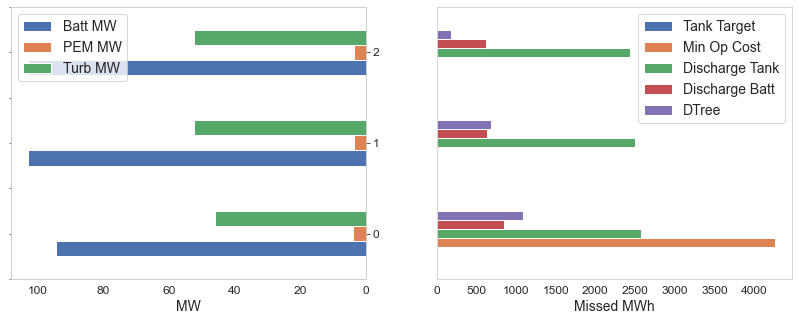

In [246]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
# design_vs_op_df[["Batt MW", "PEM MW", "Turb MW"]].plot(kind='barh', stacked=True, ax=ax[0])

design_vs_op_df[["Batt MW", "PEM MW", "Turb MW"]].plot(kind='barh', ax=ax[0])

ax[0].invert_xaxis()
ax2 = ax[0].twinx()
ax2.set_ylim(ax[0].get_ylim())
ax2.set_yticks(ax[0].get_yticks())
# ax2.set_yticklabels(ax[0].get_yticklabels())

ax[0].grid(False)
ax2.grid(False)
# plt.axis('off')
# ax[0].legend(bbox_to_anchor=(.65,-0.1), loc="upper center", ncol=3)

design_vs_op_df[[ 'Missed MW - Tank Target',
       'Missed MW - Min Op Cost', 'Missed MW - Discharge Tank',
       'Missed MW - Discharge Batt', 'Missed MW - DTree']].plot(kind='barh', ax=ax[1])
ax[1].grid(False)
# ax[1].set_yticklabels([])
# ax[1].set_yticks([])
ax[0].set_ylabel("")
ax[0].set_yticklabels([])
ax[0].set_yticks([])
ax[0].set_xlabel("MW")
ax[1].set_xlabel("Missed MWh")
ax[1].legend(labels=['Tank Target',
       'Min Op Cost', 'Discharge Tank',
       'Discharge Batt', 'DTree'])

In [247]:
design_vs_op_df.columns

Index(['Wind MW', 'Batt MW', 'Batt MWh', 'PEM MW', 'Turb MW', 'Tank Ton',
       'Capital Cost', 'NPV', 'Missed MW - Tank Target',
       'Missed MW - Min Op Cost', 'Missed MW - Discharge Tank',
       'Missed MW - Discharge Batt', 'Missed MW - DTree'],
      dtype='object')

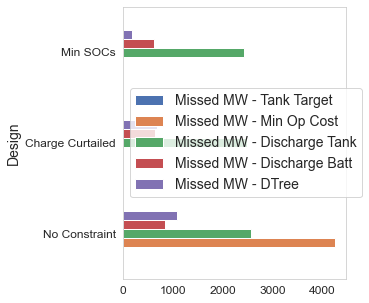

In [248]:
fig, ax = plt.subplots(figsize=(4, 5))
design_vs_op_df[[ 'Missed MW - Tank Target',
       'Missed MW - Min Op Cost', 'Missed MW - Discharge Tank',
       'Missed MW - Discharge Batt', 'Missed MW - DTree']].plot(kind='barh', ax=ax)
ax.grid(False)


tank target is ok
design opt is returning big batteries that aren't used in operation, which makes it easier for the operation models to succeed

In [249]:
print(pd.read_csv(results_dir / "tank_target_1_freeop" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())
print(pd.read_csv(results_dir / "discharge_tank_1_freeop" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())
print(pd.read_csv(results_dir / "discharge_batt_1_freeop" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())
print(pd.read_csv(results_dir / "dtree_12_1_freeop" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())
print(pd.read_csv(results_dir / "min_op_cost_24_freeop" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())

0.0
2572.54
851.9399999999999
1083.95
4264.57


In [250]:
print(pd.read_csv(results_dir / "tank_target_1_modop" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())
print(pd.read_csv(results_dir / "discharge_tank_1_modop" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())
print(pd.read_csv(results_dir / "discharge_batt_1_modop" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())
print(pd.read_csv(results_dir / "dtree_12_1_modop" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())
print(pd.read_csv(results_dir / "min_op_cost_24_modop" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())

0.0
2496.7
635.6999999999999
684.05
0.0


In [251]:
print(pd.read_csv(results_dir / "tank_target_1_minsoc" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())
print(pd.read_csv(results_dir / "discharge_tank_1_minsoc" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())
print(pd.read_csv(results_dir / "discharge_batt_1_minsoc" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())
print(pd.read_csv(results_dir / "dtree_12_1_minsoc" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())
print(pd.read_csv(results_dir / "min_op_cost_24_minsoc" / "tracker_detail.csv")["Power Underdelivered [MW]"].sum())

0.0
2435.88
624.42
181.73000000000002
0.0


In [252]:
year_results['Wind Excess [MW]'] = (year_results['Wind Max [MW]'] - year_results['Load [MW]']).clip(lower=0)
year_results['Wind Shortage [MW]'] = (year_results['Load [MW]'] - year_results['Wind Max [MW]']).clip(lower=0)
year_results['Previous State of Charge [MWh]'] = np.roll(year_results['State of Charge [MWh]'], 1)
year_results['Previous Tank Holdup [kg]'] = np.roll(year_results['Tank Holdup [kg]'], 1)
year_results['Ratio Battery Input to Nameplate [MW]'] = year_results['Wind Power to Battery [MW]'] / params['batt_mw']
year_results['Ratio PEM Input to Nameplate [MW]'] = year_results['Wind Power to PEM [MW]'] / params['pem_mw']
year_results['Ratio Battery Output to Nameplate [MW]'] = year_results['Battery Power Output [MW]'] / params['batt_mw']
year_results['Ratio Turbine Output to Nameplate [MW]'] = year_results['Turbine Power Output [MW]'] / params['turb_mw']

year_results['4-Hr Ahead Wind Excess [MW]'] = year_results['Wind Excess [MW]'][::-1].rolling(4, min_periods=0).sum()
year_results['16-Hr Ahead Wind Excess [MW]'] = year_results['Wind Excess [MW]'][::-1].rolling(16, min_periods=0).sum()
year_results['24-Hr Ahead Wind Excess [MW]'] = year_results['Wind Excess [MW]'][::-1].rolling(24, min_periods=0).sum()

year_results['4-Hr Ahead Wind Shortage [MW]'] = year_results['Wind Shortage [MW]'][::-1].rolling(4, min_periods=0).sum()
year_results['16-Hr Ahead Wind Shortage [MW]'] = year_results['Wind Shortage [MW]'][::-1].rolling(16, min_periods=0).sum()
year_results['24-Hr Ahead Wind Shortage [MW]'] = year_results['Wind Shortage [MW]'][::-1].rolling(24, min_periods=0).sum()

year_results.columns

input_cols = ['Previous State of Charge [MWh]', 'Previous Tank Holdup [kg]',
    'Wind Excess [MW]', 'Wind Shortage [MW]',  
    '4-Hr Ahead Wind Excess [MW]', 
    '16-Hr Ahead Wind Excess [MW]', '24-Hr Ahead Wind Excess [MW]',
    '4-Hr Ahead Wind Shortage [MW]', 
    '16-Hr Ahead Wind Shortage [MW]', '24-Hr Ahead Wind Shortage [MW]']
output_cols = ['Ratio Battery Input to Nameplate [MW]',
    'Ratio PEM Input to Nameplate [MW]',
    'Ratio Battery Output to Nameplate [MW]',
    'Ratio Turbine Output to Nameplate [MW]']

In [253]:
X = year_results[input_cols].to_numpy()
y = year_results[output_cols].to_numpy()

regtree = DecisionTreeRegressor(random_state=1, max_depth=12)
regfore = RandomForestRegressor(random_state=1, max_depth=10, n_estimators=2)
reglin = LinearRegression()

regtree.fit(X, y)
regfore.fit(X, y)
reglin.fit(X,y)

display(regtree.score(X, y), regfore.score(X, y), reglin.score(X, y))

# graph = graphviz.Source(export_graphviz(regtree, filled=True), format='png')
# graph.render("decision_tree_graphivz")

regtree.get_n_leaves()

0.9358849466581687

0.8403670091185074

0.2498776538714757

1151

In [254]:
sorted(list(zip(input_cols, regtree.feature_importances_)), key=lambda row: -row[1])

[('Wind Excess [MW]', 0.6809526595851905),
 ('Previous State of Charge [MWh]', 0.09275375747440397),
 ('16-Hr Ahead Wind Excess [MW]', 0.06304557302695474),
 ('Previous Tank Holdup [kg]', 0.05405928686900367),
 ('24-Hr Ahead Wind Excess [MW]', 0.05354451573409388),
 ('4-Hr Ahead Wind Excess [MW]', 0.029825763112855046),
 ('24-Hr Ahead Wind Shortage [MW]', 0.015471165269460357),
 ('Wind Shortage [MW]', 0.006563882311327824),
 ('16-Hr Ahead Wind Shortage [MW]', 0.002408954759750034),
 ('4-Hr Ahead Wind Shortage [MW]', 0.0013744418569598886)]

## Surrogate Model

In [255]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from pyvis.network import Network
from functools import reduce

from dispatches_sample_data import rts_gmlc
from dispatches.case_studies.renewables_case.double_loop_utils import *

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("deep")

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

pd.set_option('display.max_columns', None)

if os.environ.get("NREL_CLUSTER"):
    workspace_dir = Path("/projects/gmihybridsys/dguittet/workspace")
    dispatches_dir = Path("/projects/gmihybridsys/dguittet/dispatches/dispatches/case_studies/renewables_h2_case")
else:
    workspace_dir = Path("/Users/dguittet/Projects/Dispatches/workspace")
    dispatches_dir = Path("/Users/dguittet/Projects/Dispatches/dispatches/dispatches/case_studies/renewables_h2_case")

rts_gmlc_dir = workspace_dir / "prescient_runs/simulate_with_network_with_uncertainty_w_15_reserves_500_shortfall_eagle"

In [256]:
rts_gmlc_graph, line_df, branch_df, gen_df, summary = get_rtsgmlc_network(rts_gmlc_dir, rts_gmlc.source_data_path)
bus_dict = get_rtsgmlc_bus_dict(rts_gmlc.source_data_path)
bid_df = pd.read_csv(rts_gmlc.source_data_path / "gen.csv")
bid_df = bid_df[bid_df['Fuel'] == "NG"]
ng_gens = bid_df['GEN UID'].unique()
bid_df = bid_df.rename(columns={"GEN UID": "Generator"})

# heat rate compiling
bid_df["HR_avg_1"] = bid_df["HR_avg_0"] + bid_df["HR_incr_1"]
bid_df["HR_avg_2"] = bid_df["HR_avg_1"] + bid_df["HR_incr_2"]
bid_df["HR_avg_3"] = bid_df["HR_avg_1"] + bid_df["HR_incr_3"]
bid_df["HR_avg"] = (bid_df["HR_avg_0"] + bid_df["HR_avg_1"] + bid_df["HR_avg_2"] + bid_df["HR_avg_3"])/4

In [257]:
gen_df["Type"] = "NA"
gen_df.loc[gen_df['Generator'].str.contains("CC"), "Type"] = "CC"
gen_df.loc[gen_df['Generator'].str.contains("CT"), "Type"] = "CT"
gen_df[(gen_df["Type"] == "CT") | (gen_df["Type"] == "CC")].describe()

,Output,Output DA,Curtailment,Unit Market Revenue,Unit Uplift Payment,Dispatch,Dispatch DA,Headroom,Unit Cost
count,0.0,0.0,0.0,430416.000000,430416.0,430416.000000,430416.000000,430416.000000,430416.000000
mean,NaN,NaN,NaN,610.807387,0.0,15.804734,16.269232,12.121299,555.011400
std,NaN,NaN,NaN,2936.440500,0.0,53.792470,55.447145,42.560721,2369.660877
min,NaN,NaN,NaN,-9250.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,NaN,NaN,NaN,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
max,NaN,NaN,NaN,127406.477902,0.0,355.000000,355.000000,185.000000,35570.200971


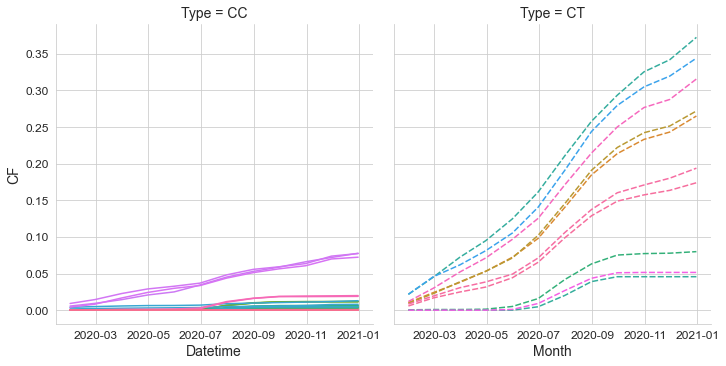

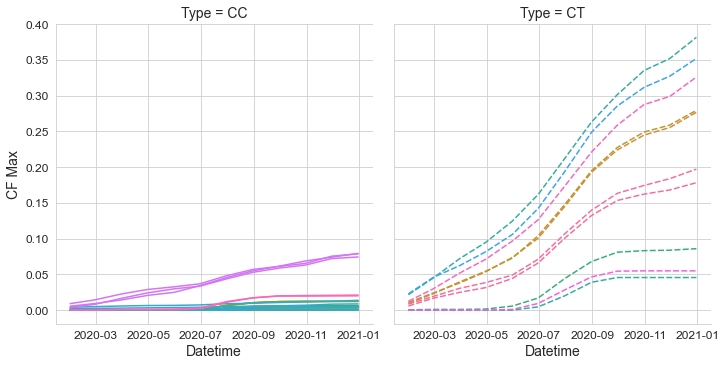

In [258]:
ng_df = gen_df.groupby("Generator").resample("1M").sum().reset_index()
ng_df["Dispatch Cml"] = ng_df.groupby('Generator').cumsum().reset_index()['Dispatch']
ng_df["Dispatch DA Cml"] = ng_df.groupby('Generator').cumsum().reset_index()['Dispatch DA']
ng_df["Type"] = "CC"
ng_df.loc[ng_df['Generator'].str.contains("CC"), "Type"] = "CT"

n_hrs = len(gen_df.index.unique())
ng_df['CF'] = 0
for gen in ng_gens:
    ng_df.loc[ng_df['Generator'] == gen, "CF"] = ng_df.loc[ng_df['Generator'] == gen, "Dispatch Cml"] / bid_df[bid_df['Generator'] ==  gen]["PMax MW"].unique()[0] / n_hrs
    ng_df.loc[ng_df['Generator'] == gen, "CF Max"] = ng_df.loc[ng_df['Generator'] == gen][["Dispatch Cml", "Dispatch DA Cml"]].max(axis=1) / bid_df[bid_df['Generator'] ==  gen]["PMax MW"].unique()[0] / n_hrs


sns.relplot(
    data=ng_df, y="CF", x="Datetime", hue="Generator", style='Type',
    col="Type", kind="line", legend=False
)
plt.xlabel("Month")

sns.relplot(
    data=ng_df, y="CF Max", x="Datetime", hue="Generator", style='Type',
    col="Type", kind="line", legend=False
)

/Users/dguittet/miniconda3/envs/dispatches/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


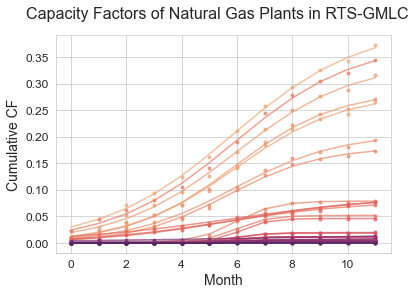

In [261]:
from scipy.optimize import curve_fit, least_squares

palette = sns.color_palette("flare", len(ng_gens))

def func(month, L, k, x_0):
    return L / (1 + np.exp(-k * (month - x_0)))

X = []
y = []
bid_df["L"] = np.nan
bid_df["L_abs"] = np.nan
bid_df["k"] = np.nan
bid_df['x_0'] = np.nan

fig = plt.figure()

xdata = np.array(range(0, 12)) / 12
ng_gens_sorted = bid_df.sort_values("HR_avg_0").Generator.unique()
for i, gen in enumerate(ng_gens_sorted):
    ydata = ng_df[ng_df['Generator'] == gen]['CF'].values
    pmax = bid_df[bid_df['Generator'] == gen]['PMax MW'].values[0]
    try:
        popt, pcov = curve_fit(func, xdata, ydata)
    except:
#         plt.plot(xdata, ydata, 'b-', label='data, no fit')
        continue
    # display(popt)
    plt.scatter(range(0, 12), ydata, label='data', marker='.', color=palette[i], alpha=0.7)
    plt.plot(range(0, 12), func(xdata, *popt), '-', label='fit: L=%5.3f, k=%5.3f, x_0=%5.3f' % tuple(popt), color=palette[i], alpha=0.7)
    # plt.legend()
    # X.append()
    if popt[1] < 0:
        continue
    bid_df.loc[bid_df['Generator'] == gen, "L"] = popt[0]
    bid_df.loc[bid_df['Generator'] == gen, "L_abs"] = popt[0] * pmax * n_hrs
    bid_df.loc[bid_df['Generator'] == gen, "k"] = popt[1]
    bid_df.loc[bid_df['Generator'] == gen, "x_0"] = popt[2]
    # break
plt.xlabel("Month")
plt.ylabel("Cumulative CF")
plt.suptitle("Capacity Factors of Natural Gas Plants in RTS-GMLC")

fit_df = bid_df.drop(columns=bid_df.columns[bid_df.isna().any()].tolist()[:-4])
fit_df = fit_df.dropna(axis=0)

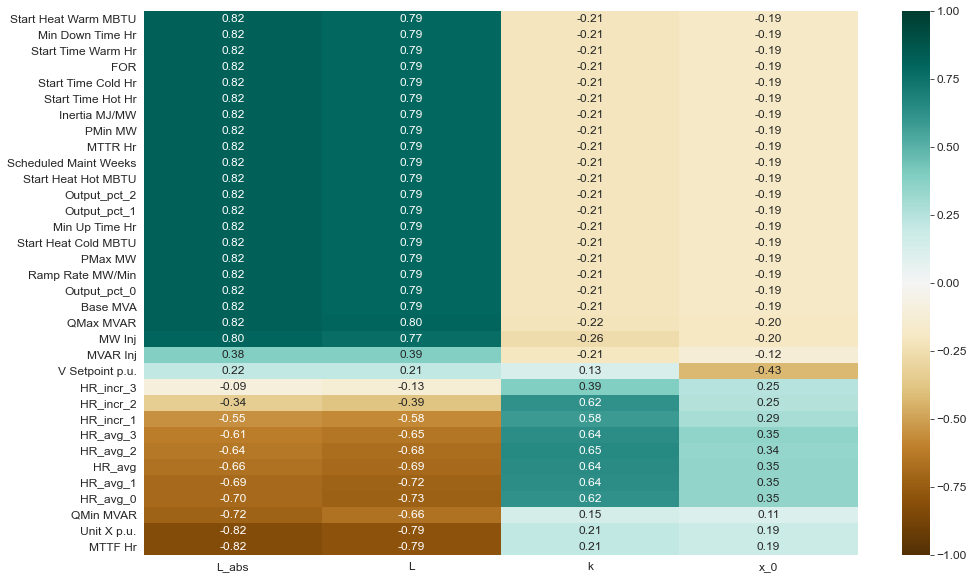

In [225]:
output_cols = ["L_abs", "L", 'k', 'x_0']
input_cols = set(fit_df.columns).difference(set(output_cols))
corr_df = fit_df.dropna(axis=1).drop(columns=["Bus ID", "Gen ID"])
corr_df = corr_df.corr().loc[corr_df.corr().index.isin(input_cols)][output_cols].dropna(axis=0)
input_cols = corr_df.index
plt.figure(figsize=(16, 10))
heatmap = sns.heatmap(corr_df.sort_values(by=output_cols, ascending=False), vmin=-1, vmax=1, cmap='BrBG', annot=True, fmt=".2f")


,L_abs,L,k,x_0
count,3.300000e+01,3.300000e+01,33.000000,33.000000
mean,2.189991e+05,8.068767e-02,52.626111,0.526443
std,3.929063e+05,1.223919e-01,133.948150,0.122057
min,1.092059e-164,2.260430e-170,1.000000,0.458398
25%,1.960216e+03,4.057410e-03,5.677239,0.490665
50%,8.210904e+03,1.699558e-02,23.428050,0.494997
75%,1.615857e+05,8.587489e-02,30.501825,0.497452
max,1.269082e+06,4.069761e-01,583.097585,0.999999


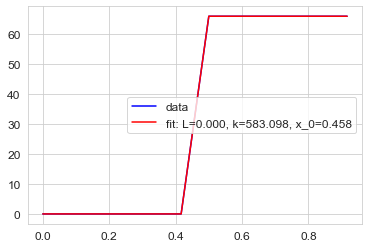

In [226]:
for i, tmp in fit_df.sort_values("x_0").head(1).iterrows():
    gen = tmp['Generator']
    ydata = ng_df[ng_df['Generator'] == gen]['CF'].values
    plt.figure()
    plt.plot(xdata, ydata * n_hrs * pmax, 'b-', label='data')
    popt = tmp["L"], tmp['k'], tmp['x_0']
    plt.plot(xdata, func(xdata, *popt)* n_hrs * pmax, 'r-', label='fit: L=%5.3f, k=%5.3f, x_0=%5.3f' % tuple(popt))
plt.legend()

fit_df[output_cols].describe()

## Figure out how to model the shape of the Sigmoids

In [227]:
bid_df[bid_df['Generator'].isin(ng_gens)]['PMax MW'].unique()

array([355.,  55.])

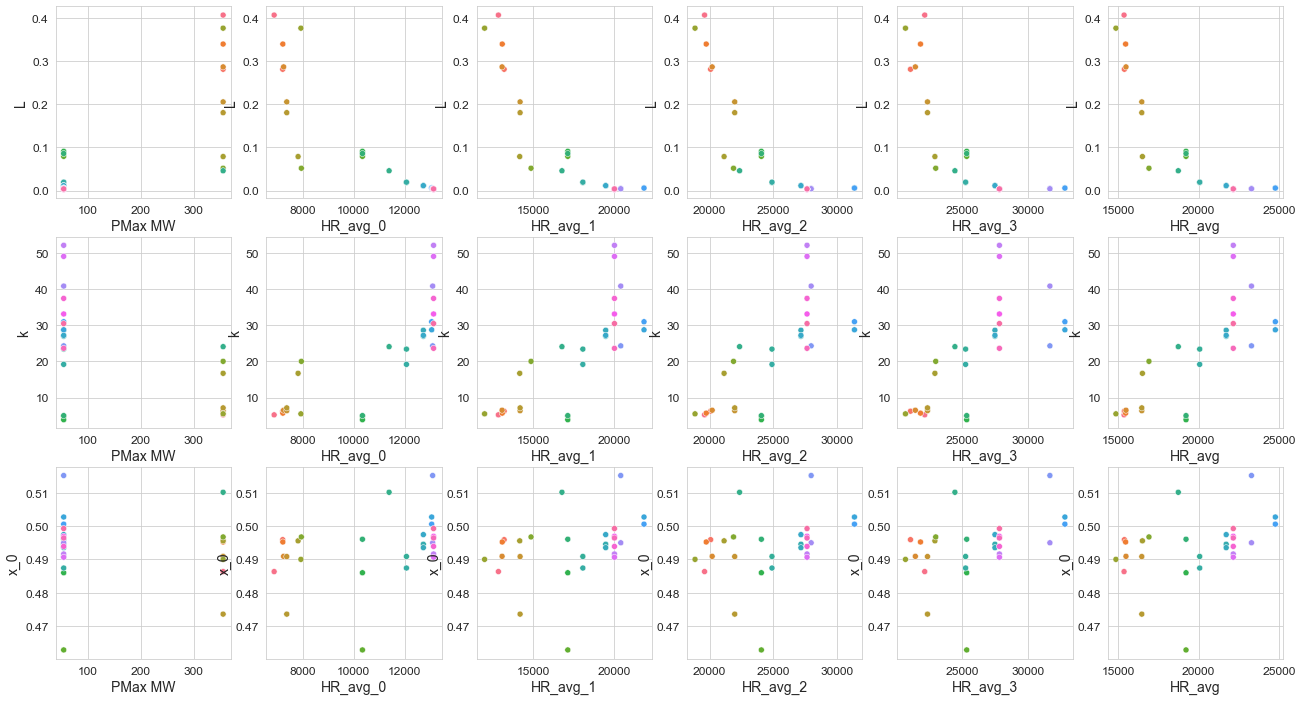

In [228]:
# drop some outliers
fit_df = fit_df.sort_values("HR_avg_0").head(-2)
fit_df = fit_df[fit_df['x_0'] < 0.6]

xvals = ["PMax MW", "HR_avg_0", "HR_avg_1", "HR_avg_2", "HR_avg_3", "HR_avg"]
# xvals = ["PMax MW", "HR_avg_0", "HR_incr_1", "HR_incr_2", "HR_incr_3", "HR_avg"]
yvals = ["L", "k", "x_0"]
fig, ax = plt.subplots(len(yvals), len(xvals), figsize=(22, 12))

for r, yval in enumerate(yvals):
    for c, xval in enumerate(xvals):
        sns.scatterplot(ax=ax[r, c],
            data=fit_df.sort_values("HR_avg_0"), y=yval, x=xval, hue="Generator", legend=False
        )

[ 1.00018656  0.98806485 20.10277705  0.58095244]


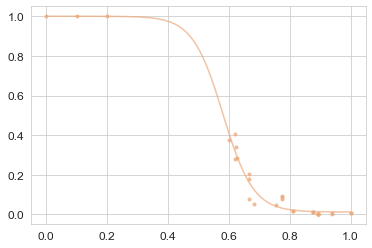

In [229]:
# Add parameters to the sigmoid curve
# def func(month, L, k, x_0):
#     return L / (1 + np.exp(-k * (month - x_0)))

def func(x, A, b, c, d):
    return A - b / (1 + np.exp(-c * (x - d)))

xdata = np.append(fit_df['HR_avg'].values / fit_df['HR_avg'].max(), [0, 0.1, 0.2])
ydata = np.append(fit_df['L'].values, [1, 1, 1])
popt, pcov = curve_fit(func, xdata, ydata)
print(popt)
plt.scatter(xdata, ydata, label='data', marker='.', color=palette[0], alpha=0.7)
x = np.linspace(0, max(xdata), 100)
plt.plot(x, func(x, *popt), '-', label='fit: A=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt), color=palette[0], alpha=0.7)

In [230]:
fit_df['HR_avg'].mean()

19768.928571428572

[ 1.02629252  1.01123212 17.05785693  0.58490096  0.05185369]


/var/folders/yh/xvlf1svn0xq6r2l4hzsggz2xt3qfdr/T/ipykernel_86373/2919807938.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks)
/var/folders/yh/xvlf1svn0xq6r2l4hzsggz2xt3qfdr/T/ipykernel_86373/2919807938.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.array(ax.get_yticks() * fit_df['PMax MW'].max(), dtype='int'))


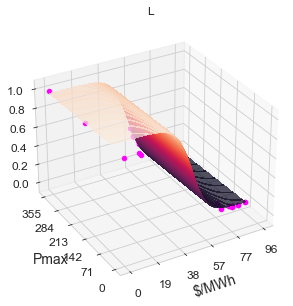

In [231]:
def funcL(x, a, b, c, d, e):
    return a - (b / (1 + np.exp(-c * (x[0] - d))) + (e * x[1]))

xdata1 = np.append(fit_df['PMax MW'].values / fit_df['PMax MW'].max(), [0, 0.5, 1])
xdata0 = np.append(fit_df['HR_avg'].values / fit_df['HR_avg'].max(), [0, 0, 0])
ydata = np.append(fit_df['L'].values, [1, 1, 1])

xdata = np.array(list(zip(xdata0, xdata1))).T
popt, pcov = curve_fit(funcL, xdata, ydata)
print(popt)

@np.vectorize
def fit_L(x, y):
    return funcL([x, y], *popt)
    
hr = np.linspace(0, fit_df["HR_avg"].max(), 200) / fit_df['HR_avg'].max()
pmax = np.linspace(fit_df['PMax MW'].min(), fit_df['PMax MW'].max(), 200) / fit_df['PMax MW'].max()

fig = plt.figure(figsize=(12, 5))
# sharex=True, sharey=True, projection='3d')
ax = fig.add_subplot(1, 2, 1, projection='3d')
X, Y = np.meshgrid(hr, pmax)

for x, y, z in zip(xdata0, xdata1, ydata):
    ax.scatter(x, y, z, marker='o', color='magenta')

Z = fit_L(X, Y)
g = ax.contourf(X, Y, Z, 200, alpha=0.7)
ax.set_xlabel("$/MWh")
ax.set_ylabel("Pmax")
ax.set_title("L")

xticks = np.array(ax.get_xticks() * fit_df['HR_avg'].max() * 3.88722 * 1e-3, dtype='int')
ax.set_xticklabels(xticks)
ax.set_yticklabels(np.array(ax.get_yticks() * fit_df['PMax MW'].max(), dtype='int'))
ax.view_init(elev=ax.elev, azim=60+180)


[ 3.53584885 -0.04961989  1.          1.        ]
[9.5493854  0.41719046 1.         1.        ]


/var/folders/yh/xvlf1svn0xq6r2l4hzsggz2xt3qfdr/T/ipykernel_86373/3536742046.py:2: RuntimeWarning: overflow encountered in exp
  return np.exp(a * (x - b))
/Users/dguittet/miniconda3/envs/dispatches/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/yh/xvlf1svn0xq6r2l4hzsggz2xt3qfdr/T/ipykernel_86373/3536742046.py:2: RuntimeWarning: overflow encountered in exp
  return np.exp(a * (x - b))
/Users/dguittet/miniconda3/envs/dispatches/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Text(0.5, 0, 'HR')

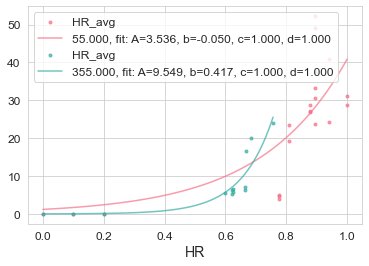

In [232]:
def func(x, a, b, c, d):
    return np.exp(a * (x - b)) 

palette = sns.color_palette("husl", 2)
for i, pmax in enumerate((55, 355)):
    xdata = np.append(fit_df[fit_df['PMax MW'] == pmax]['HR_avg'].values / fit_df['HR_avg'].max(), [0, 0.1, 0.2])
    ydata = np.append(fit_df[fit_df['PMax MW'] == pmax]['k'].values, [0, 0, 0])
    popt, pcov = curve_fit(func, xdata, ydata)
    print(popt)
    plt.scatter(xdata, ydata, label='HR_avg', marker='.', color=palette[i], alpha=0.7)
    x = np.linspace(0, max(xdata), 100)
    plt.plot(x, func(x, *popt), '-', label='%5.3f, fit: A=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % (pmax, *popt), color=palette[i], alpha=0.7)
plt.legend()
plt.xlabel("HR")

[ 3.74120819e+00 -5.37332591e-02  2.89280716e-03]


/var/folders/yh/xvlf1svn0xq6r2l4hzsggz2xt3qfdr/T/ipykernel_86373/2914103002.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks)
/var/folders/yh/xvlf1svn0xq6r2l4hzsggz2xt3qfdr/T/ipykernel_86373/2914103002.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.array(ax.get_yticks() * fit_df['PMax MW'].max(), dtype='int'))


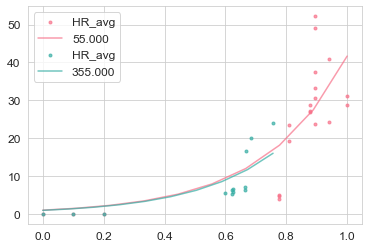

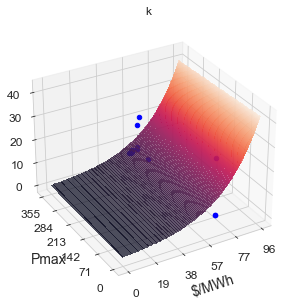

In [233]:
def funck(x, a, b, c):
    return np.exp(a * x[0] + b * x[1] - c)

xdata0 = np.append(fit_df['HR_avg'].values / fit_df['HR_avg'].max(), [0, 0, 0])
xdata1 = np.append(fit_df['PMax MW'].values / fit_df['PMax MW'].max(), [0, 0.5, 1])
ydata = np.append(fit_df['k'].values, [0, 0, 0])
xdata = np.array(list(zip(xdata0, xdata1))).T
popt, pcov = curve_fit(funck, xdata, ydata)
print(popt)

palette = sns.color_palette("husl", 2)
for i, pmax in enumerate((55, 355)):
    xdata = np.append(fit_df[fit_df['PMax MW'] == pmax]['HR_avg'].values / fit_df['HR_avg'].max(), [0, 0.1, 0.2])
    ydata = np.append(fit_df[fit_df['PMax MW'] == pmax]['k'].values, [0, 0, 0])
    plt.scatter(xdata, ydata, label='HR_avg', marker='.', color=palette[i], alpha=0.7)
    
    x = np.linspace(0, max(xdata), 10)
    xf = np.array(list(zip(x, [pmax / fit_df['PMax MW'].max()] * len(x)))).T
    y = funck(xf, *popt)
    plt.plot(x, y, '-', label='%5.3f' % pmax, color=palette[i], alpha=0.7)
plt.legend()

@np.vectorize
def fit_k(x, y):
    return funck([x, y], *popt)
    
hr = np.linspace(0, fit_df["HR_avg"].max(), 200) / fit_df['HR_avg'].max()
pmax = np.linspace(0, fit_df['PMax MW'].max(), 200) / fit_df['PMax MW'].max()

fig = plt.figure(figsize=(12, 5))
# sharex=True, sharey=True, projection='3d')
ax = fig.add_subplot(1, 2, 1, projection='3d')
X, Y = np.meshgrid(hr, pmax)

Z = fit_k(X, Y)
g = ax.contourf(X, Y, Z, 200, alpha=0.7)
ax.set_xlabel("$/MWh")
ax.set_ylabel("Pmax")
ax.set_title("k")

for x, y, z in zip(xdata0, xdata1, ydata):
    ax.scatter(x, y, z, marker='o', color='b')

xticks = np.array(ax.get_xticks() * fit_df['HR_avg'].max() * 3.88722 * 1e-3, dtype='int')
ax.set_xticklabels(xticks)
ax.set_yticklabels(np.array(ax.get_yticks() * fit_df['PMax MW'].max(), dtype='int'))
ax.view_init(elev=ax.elev, azim=60+180)

## Fit Revenue

In [234]:
gen_df["LMP DA"] = np.nan
gen_df["LMP"] = np.nan
for gen in ng_df.Generator.unique():
    bus = gen[0:3]
    bus_name = bus_dict[int(bus)]
    gen_df.loc[gen_df["Generator"] == gen, "LMP DA"] = summary[summary['Bus'] == bus_name]["LMP DA"].values
    gen_df.loc[gen_df["Generator"] == gen, "LMP"] = summary[summary['Bus'] == bus_name]["LMP"].values

In [235]:
gen_df['Revenue DA'] = gen_df['Dispatch DA'] * gen_df['LMP DA']
gen_df['Revenue RT'] = (gen_df['Dispatch'] - gen_df['Dispatch DA']) * gen_df['LMP']
gen_df['Revenue'] = gen_df['Revenue RT']  + gen_df['Revenue DA']
gen_df['Revenue Per MWh'] = gen_df['Revenue'] / gen_df[['Dispatch', 'Dispatch DA']].max(axis=1)
gen_df['Revenue DA Per MWh'] = gen_df['Revenue DA'] / gen_df['Dispatch DA']
gen_df['Revenue RT Per MWh'] = gen_df['Revenue RT'] / gen_df['Dispatch']
gen_df['Revenue RT Per MWh'] = gen_df['Revenue RT Per MWh'].replace(0, np.nan)
gen_df['Revenue DA Per MWh'] = gen_df['Revenue DA Per MWh'].replace(0, np.nan)
gen_df['Revenue Per MWh'] = gen_df['Revenue Per MWh'].replace(0, np.nan)

gen_monthly = gen_df.groupby("Generator").resample('1M').mean().reset_index()
gen_monthly["Type"] = "NA"
gen_monthly.loc[gen_monthly['Generator'].str.contains("CC"), "Type"] = "CC"
gen_monthly.loc[gen_monthly['Generator'].str.contains("CT"), "Type"] = "CT"
gen_monthly = gen_monthly[gen_monthly['Generator'].isin(bid_df.Generator.unique())]

for gen in bid_df.Generator.unique():
    bus = gen[0:3]
    gen_monthly.loc[gen_monthly['Generator'] == gen, "Bus"] = bus_dict[int(bus)]
    gen_monthly.loc[gen_monthly['Generator'] == gen, "HR_avg"] = bid_df[bid_df['Generator'] == gen]["HR_avg"].values[0]
    gen_monthly.loc[gen_monthly['Generator'] == gen, "PMax MW"] = bid_df[bid_df['Generator'] == gen]["PMax MW"].values[0]

gen_monthly["LMP Max"] = gen_monthly[["LMP", "LMP DA"]].max(axis=1)
gen_monthly['HR_avg_rnd'] = (gen_monthly['HR_avg'] * 1e-3).round() * 1e3
gen_monthly['HR_avg_rnd'].unique()
# gen_monthly['Revenue RT Per MWh'] = gen_monthly['Revenue RT Per MWh'].fillna(0)
# gen_monthly['Revenue DA Per MWh'] = gen_monthly['Revenue DA Per MWh'].fillna(0)
# gen_monthly['Revenue Per MWh'] = gen_monthly['Revenue Per MWh'].fillna(0)
gen_monthly['Delta Revenue Per MWh'] = gen_monthly['Revenue Per MWh'] - gen_monthly['HR_avg'] * 1e-3 * 3.8872

In [236]:
ng_df = gen_df[gen_df['Generator'].str.contains("CC") | (gen_df['Generator'].str.contains("CT"))]
ng_df[ng_df['Revenue RT Per MWh'] < 20]

,Generator,Output,Output DA,Curtailment,Unit Market Revenue,Unit Uplift Payment,Dispatch,Dispatch DA,Headroom,Unit State,Unit Cost,Type,LMP DA,LMP,Revenue DA,Revenue RT,Revenue,Revenue Per MWh,Revenue DA Per MWh,Revenue RT Per MWh
Datetime,,,,,,,,,,,,,,,,,,,,
2020-01-01 16:00:00,107_CC_1,NaN,NaN,NaN,6171.995572,0.0,170.000000,231.700000,185.000000,True,4772.495483,CC,29.504829,19.430296,6836.268879,-1198.849263,5637.419616,24.330685,29.504829,-7.052054
2020-01-01 16:00:00,118_CC_1,NaN,NaN,NaN,5784.877698,0.0,170.000000,231.700000,185.000000,True,4795.624442,CC,29.223287,19.430296,6771.035598,-1198.849263,5572.186335,24.049143,29.223287,-7.052054
2020-01-01 16:00:00,321_CC_1,NaN,NaN,NaN,6340.324666,0.0,170.000000,231.700000,185.000000,True,4775.799620,CC,30.231325,19.430296,7004.598002,-1198.849263,5805.748739,25.057181,30.231325,-7.052054
2020-01-01 17:00:00,107_CC_1,NaN,NaN,NaN,21834.135570,0.0,170.000000,231.700000,185.000000,True,4772.495483,CC,73.507351,22.082944,17031.653227,-1362.517645,15669.135582,67.626826,73.507351,-8.014810
2020-01-01 17:00:00,118_CC_1,NaN,NaN,NaN,21645.332138,0.0,170.000000,231.700000,185.000000,True,4795.624442,CC,72.576747,20.600334,16816.032280,-1271.040608,15544.991672,67.091030,72.576747,-7.476709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 22:00:00,107_CC_1,NaN,NaN,NaN,5634.828861,0.0,231.700000,170.000000,123.300000,True,6204.352970,CC,24.209791,24.621790,4115.664470,1519.164443,5634.828913,24.319503,24.209791,6.556601
2020-12-31 22:00:00,213_CC_3,NaN,NaN,NaN,5094.316011,0.0,209.747378,170.000000,145.252622,True,6148.965175,CC,24.209791,24.621790,4115.664470,978.651594,5094.316064,24.287865,24.209791,4.665859
2020-12-31 22:00:00,221_CC_1,NaN,NaN,NaN,5619.760944,0.0,231.700000,206.572666,123.300000,True,5978.155638,CC,24.209791,24.621790,5001.081070,618.679941,5619.761011,24.254471,24.209791,2.670177


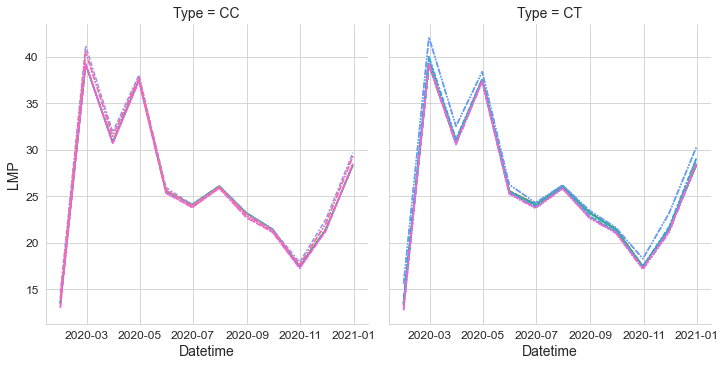

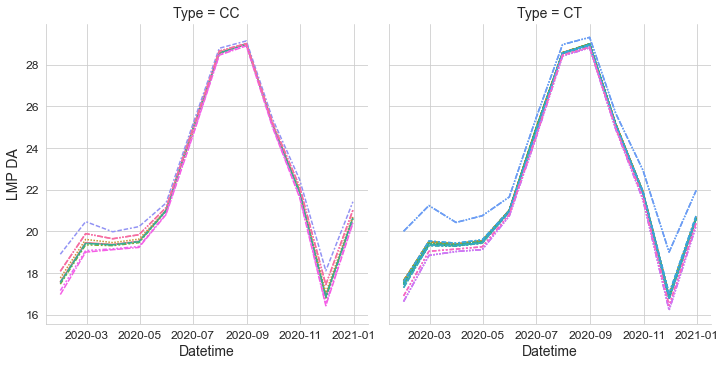

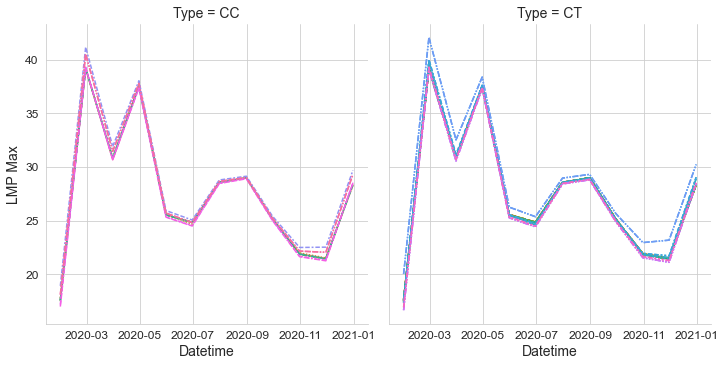

In [237]:
sns.relplot(
    data=gen_monthly, y="LMP", x="Datetime", hue="Generator", style='Bus',
    col="Type", kind="line", legend=False
)
sns.relplot(
    data=gen_monthly, y="LMP DA", x="Datetime", hue="Generator", style='Bus',
    col="Type", kind="line", legend=False
)
sns.relplot(
    data=gen_monthly, y="LMP Max", x="Datetime", hue="Generator", style='Bus',
    col="Type", kind="line", legend=False
)

In [238]:
gen_monthly.HR_avg.unique()

array([15386.  , 22149.  , 15485.75, 21709.  , 24763.  , 16506.5 ,
       23082.  , 18734.25, 15365.75, 32215.5 , 23279.75, 26868.  ,
       22895.75, 14860.75, 19214.5 , 16913.5 , 15462.5 , 20064.5 ,
       16468.  ])

ValueError: Could not interpret value `Ratio Revenue Per MWh` for parameter `y`

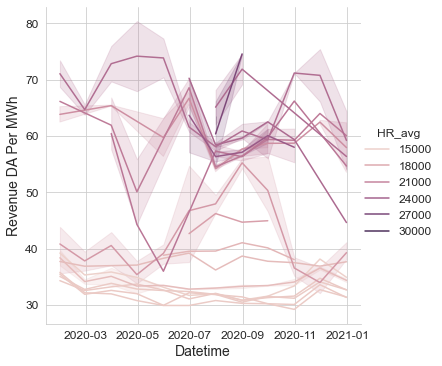

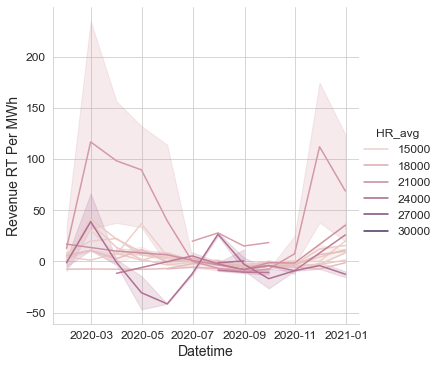

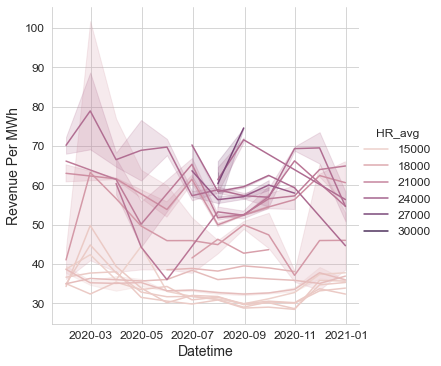

In [239]:
sns.relplot(
    data=gen_monthly, y="Revenue DA Per MWh", x="Datetime", hue="HR_avg",
    kind="line", legend=True
)

sns.relplot(
    data=gen_monthly, y="Revenue RT Per MWh", x="Datetime", hue="HR_avg",
    kind="line", legend=True
)

sns.relplot(
    data=gen_monthly, y="Revenue Per MWh", x="Datetime", hue="HR_avg",
    kind="line", legend=True
)

sns.relplot(
    data=gen_monthly, y="Ratio Revenue Per MWh", x="Datetime", hue="HR_avg",
    kind="line", legend=True
)

In [ ]:
gen_monthly.columns

Index(['Generator', 'Datetime', 'Output', 'Output DA', 'Curtailment',
       'Unit Market Revenue', 'Unit Uplift Payment', 'Dispatch', 'Dispatch DA',
       'Headroom', 'Unit Cost', 'LMP DA', 'LMP', 'Revenue DA', 'Revenue RT',
       'Revenue', 'Revenue Per MWh', 'Revenue DA Per MWh',
       'Revenue RT Per MWh', 'Type', 'Bus', 'HR_avg', 'PMax MW', 'LMP Max',
       'HR_avg_rnd', 'Delta Revenue Per MWh'],
      dtype='object')

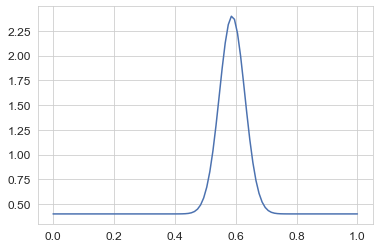

In [ ]:
x = np.linspace(0, 1, 100)
plt.plot(x, 2 * np.exp(-(17*x-10)**2) + .4)

/Users/dguittet/miniconda3/envs/dispatches/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/Users/dguittet/miniconda3/envs/dispatches/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/Users/dguittet/miniconda3/envs/dispatches/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


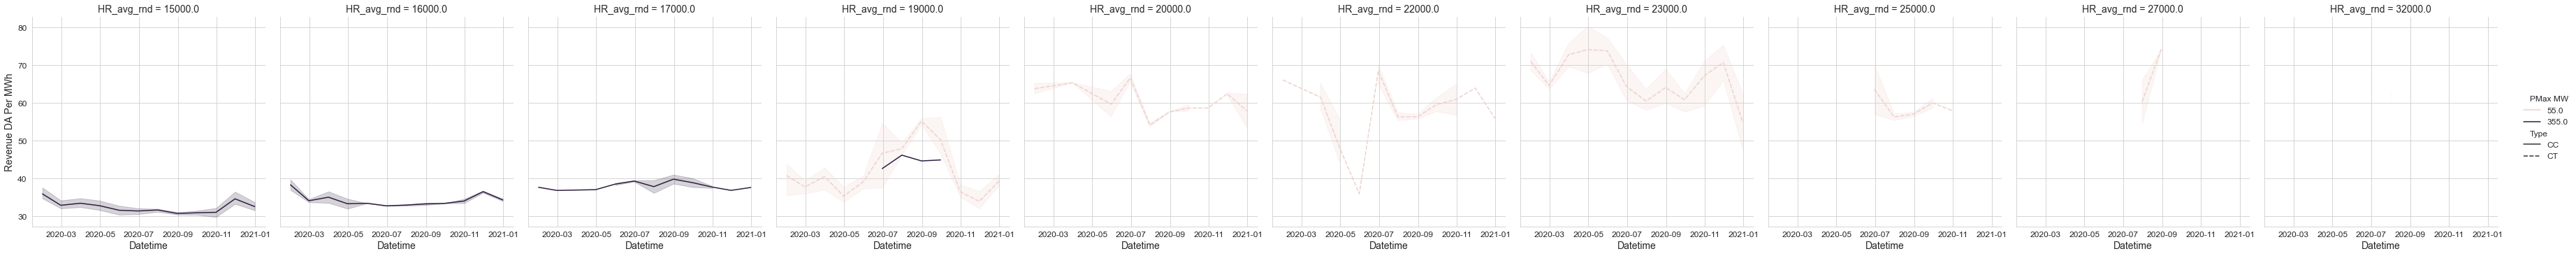

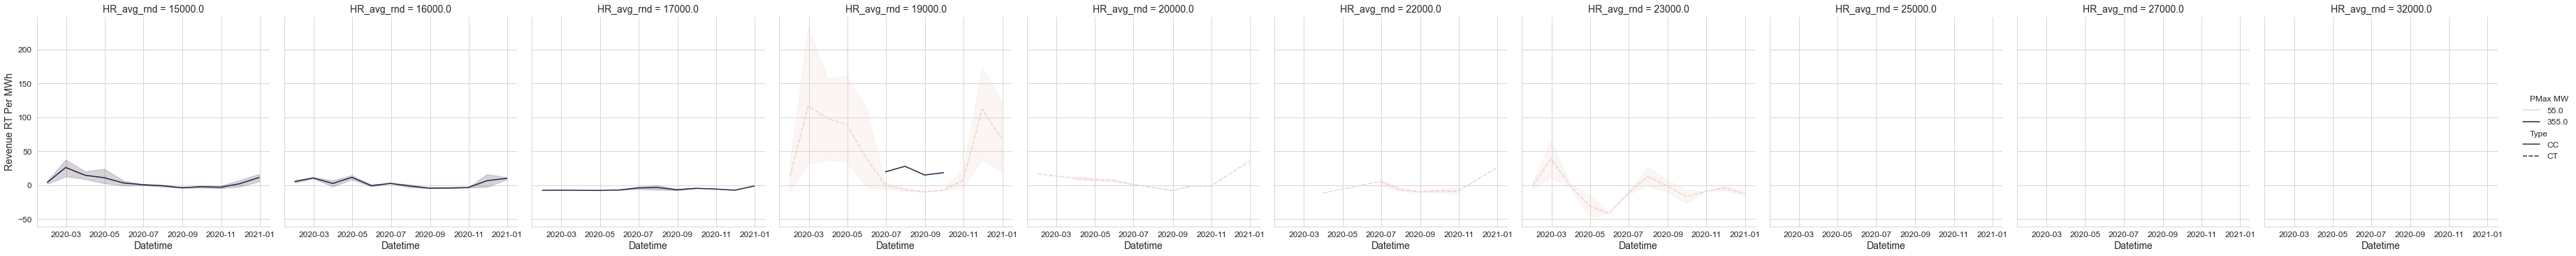

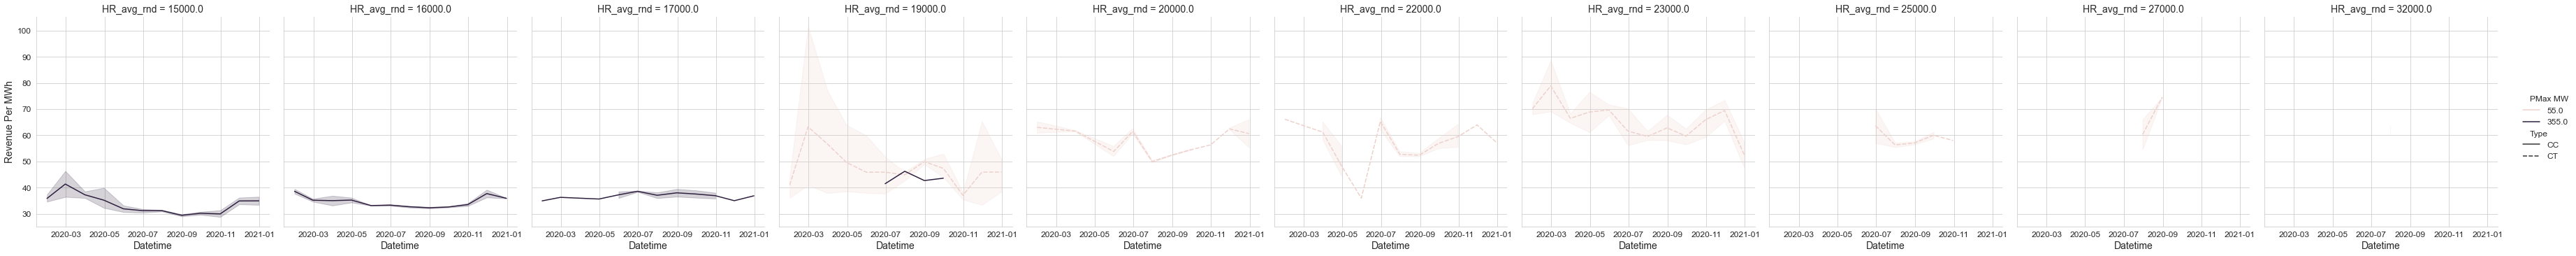

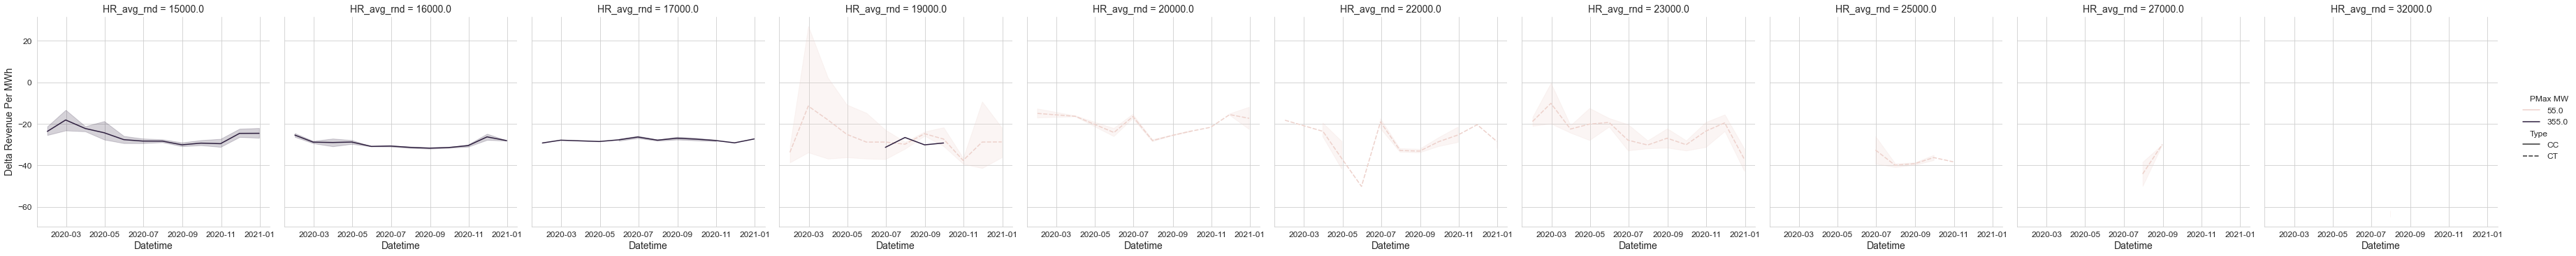

In [ ]:
sns.relplot(
    data=gen_monthly, y="Revenue DA Per MWh", x="Datetime", hue="PMax MW", style="Type",
    col="HR_avg_rnd", kind="line", legend=True
)

sns.relplot(
    data=gen_monthly, y="Revenue RT Per MWh", x="Datetime", hue="PMax MW",style="Type",
    col="HR_avg_rnd", kind="line", legend=True
)

sns.relplot(
    data=gen_monthly, y="Revenue Per MWh", x="Datetime", hue="PMax MW",style="Type",
    col="HR_avg_rnd", kind="line", legend=True
)

sns.relplot(
    data=gen_monthly, y="Delta Revenue Per MWh", x="Datetime", hue="PMax MW",style="Type",
    col="HR_avg_rnd", kind="line", legend=True
)

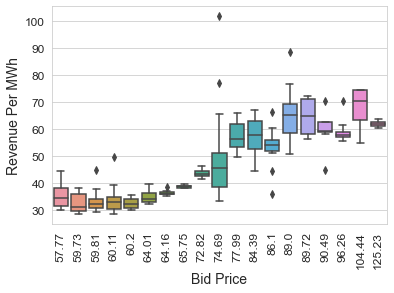

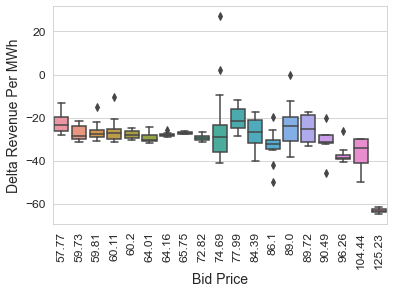

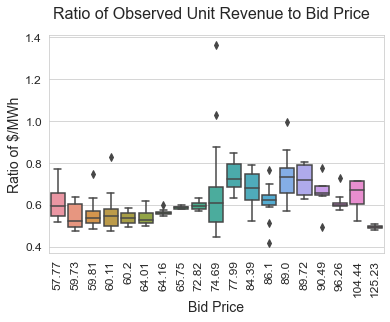

In [ ]:
gen_monthly['Bid Price'] = (gen_monthly['HR_avg'] * 1e-3 * 3.8872).round(2)
gen_monthly['DeltaN Revenue Per MWh'] = gen_monthly['Delta Revenue Per MWh'] / gen_monthly['Bid Price']
gen_monthly['Ratio Revenue Per MWh'] = gen_monthly['Revenue Per MWh'] / gen_monthly['Bid Price']
gen_yearly = gen_monthly.set_index("Datetime").groupby("Generator").resample("1Y").mean().reset_index()

sns.boxplot( data=gen_monthly, y="Revenue Per MWh", x="Bid Price")
plt.xticks(rotation=90)
plt.show()
sns.boxplot(data=gen_monthly, y="Delta Revenue Per MWh", x="Bid Price")
plt.xticks(rotation=90)
plt.show()
sns.boxplot(data=gen_monthly, y="Ratio Revenue Per MWh", x="Bid Price")
plt.suptitle("Ratio of Observed Unit Revenue to Bid Price")
plt.ylabel("Ratio of $/MWh")
plt.xticks(rotation=90)
plt.show()

In [ ]:
gen_monthly['Ratio Revenue Per MWh'].mean()

0.6269274494552742

/Users/dguittet/miniconda3/envs/dispatches/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/dguittet/miniconda3/envs/dispatches/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


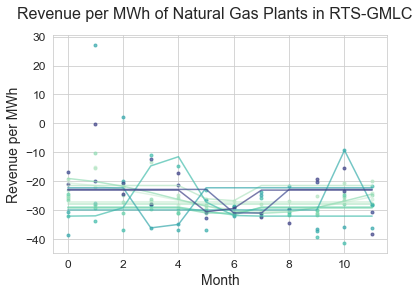

In [ ]:
from scipy.optimize import curve_fit, least_squares

palette = sns.color_palette("mako_r", len(ng_gens))

def func(month, a, b, c, d):
    return a * np.exp(-(b*month-c)**2) + d

X = []
y = []
bid_df["a"] = np.nan
bid_df["b"] = np.nan
bid_df["c"] = np.nan
bid_df['d'] = np.nan


xdata = np.array(range(0, 12)) / 12
ng_gens_sorted = gen_monthly.sort_values("HR_avg_rnd").Generator.unique()
for i, gen in enumerate(ng_gens_sorted):
    ydata = gen_monthly[gen_monthly['Generator'] == gen]['Delta Revenue Per MWh'].values
    pmax = bid_df[bid_df['Generator'] == gen]['PMax MW'].values[0]

    # fig = plt.figure()
    try:
        p0 = [
            ydata.max() - ydata.min(),
            20,
            10, 
            max(ydata.min(), 0)
        ]
        popt, pcov = curve_fit(func, xdata, ydata, p0=p0)
    except:
#         plt.plot(xdata, ydata, 'b-', label='data, no fit')
        continue
    # display(popt)
    plt.scatter(range(0, 12), ydata, label='data', marker='.', color=palette[i], alpha=0.7)
    plt.plot(range(0, 12), func(xdata, *popt), '-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt), color=palette[i], alpha=0.7)
    # plt.legend()
    # X.append()
    if popt[1] < 0:
        continue
    bid_df.loc[bid_df['Generator'] == gen, "a"] = popt[0]
    bid_df.loc[bid_df['Generator'] == gen, "b"] = popt[1]
    bid_df.loc[bid_df['Generator'] == gen, "c"] = popt[2]
    bid_df.loc[bid_df['Generator'] == gen, "d"] = popt[3]
    # break
plt.xlabel("Month")
plt.ylabel("Revenue per MWh")
plt.suptitle("Revenue per MWh of Natural Gas Plants in RTS-GMLC")

fit_df = bid_df.drop(columns=bid_df.columns[bid_df.isna().any()].tolist()[:-4])
fit_df = fit_df.dropna(axis=0)

/Users/dguittet/miniconda3/envs/dispatches/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


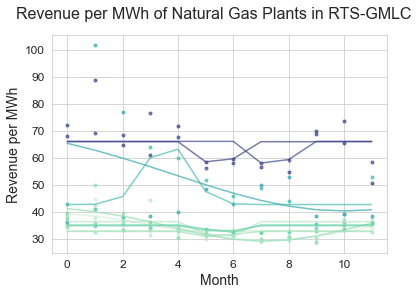

In [ ]:
from scipy.optimize import curve_fit, least_squares

palette = sns.color_palette("mako_r", len(ng_gens))

def func(month, a, b, c, d):
    return a * np.exp(-(b*month-c)**2) + d

X = []
y = []
bid_df["a"] = np.nan
bid_df["b"] = np.nan
bid_df["c"] = np.nan
bid_df['d'] = np.nan


xdata = np.array(range(0, 12)) / 12
ng_gens_sorted = gen_monthly.sort_values("HR_avg_rnd").Generator.unique()
for i, gen in enumerate(ng_gens_sorted):
    ydata = gen_monthly[gen_monthly['Generator'] == gen]['Revenue Per MWh'].values
    pmax = bid_df[bid_df['Generator'] == gen]['PMax MW'].values[0]

    # fig = plt.figure()
    try:
        p0 = [
            ydata.max() - ydata.min(),
            20,
            10, 
            max(ydata.min(), 0)
        ]
        popt, pcov = curve_fit(func, xdata, ydata, p0=p0)
    except:
#         plt.plot(xdata, ydata, 'b-', label='data, no fit')
        continue
    # display(popt)
    plt.scatter(range(0, 12), ydata, label='data', marker='.', color=palette[i], alpha=0.7)
    plt.plot(range(0, 12), func(xdata, *popt), '-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt), color=palette[i], alpha=0.7)
    # plt.legend()
    # X.append()
    if popt[1] < 0:
        continue
    bid_df.loc[bid_df['Generator'] == gen, "a"] = popt[0]
    bid_df.loc[bid_df['Generator'] == gen, "b"] = popt[1]
    bid_df.loc[bid_df['Generator'] == gen, "c"] = popt[2]
    bid_df.loc[bid_df['Generator'] == gen, "d"] = popt[3]
    # break
plt.xlabel("Month")
plt.ylabel("Revenue per MWh")
plt.suptitle("Revenue per MWh of Natural Gas Plants in RTS-GMLC")

fit_df = bid_df.drop(columns=bid_df.columns[bid_df.isna().any()].tolist()[:-4])
fit_df = fit_df.dropna(axis=0)

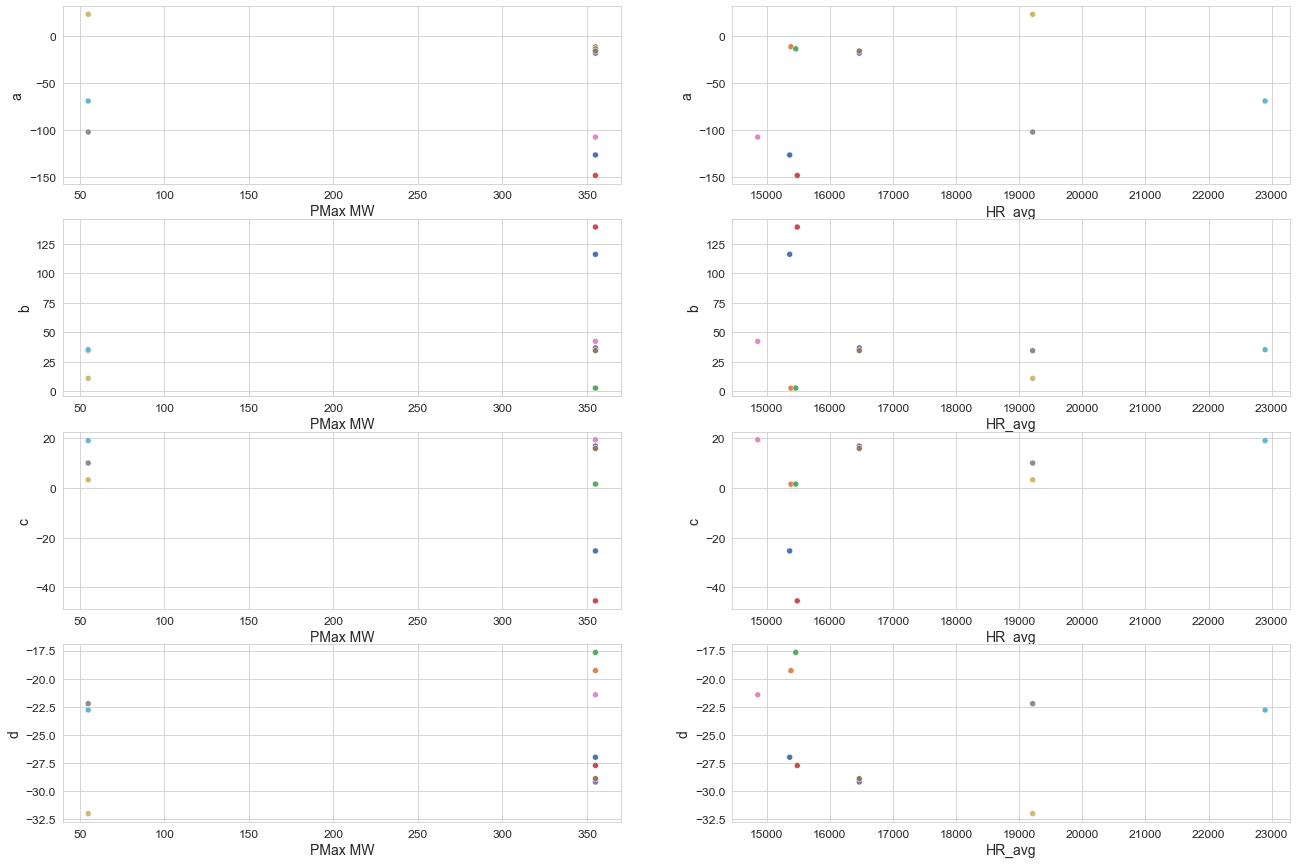

In [ ]:
xvals = ["PMax MW", "HR_avg"]
yvals = ["a", "b", "c", "d"]
fig, ax = plt.subplots(len(yvals), len(xvals), figsize=(22, 15))

for r, yval in enumerate(yvals):
    for c, xval in enumerate(xvals):
        sns.scatterplot(ax=ax[r, c],
            data=fit_df.sort_values("HR_avg_0").head(-1), y=yval, x=xval, hue="Generator", legend=False
        )

In [ ]:
fit_df[yvals].describe()

,a,b,c,d
count,11.000000,11.000000,11.000000,11.000000
mean,-56.596320,44.002375,2.766247,-24.672595
std,56.499687,43.898988,20.501740,4.561828
min,-148.079274,2.478113,-45.438397,-32.028985
25%,-104.571398,20.679749,1.502338,-28.330742
50%,-34.952861,34.368365,9.981989,-23.041507
75%,-14.581594,39.416483,16.333926,-21.840385
max,23.286394,139.085799,19.345530,-17.673941


[-144.50261852  105.98620026    9.21781108]


/var/folders/yh/xvlf1svn0xq6r2l4hzsggz2xt3qfdr/T/ipykernel_86373/3158848649.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks)
/var/folders/yh/xvlf1svn0xq6r2l4hzsggz2xt3qfdr/T/ipykernel_86373/3158848649.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.array(ax.get_yticks() * fit_df['PMax MW'].max(), dtype='int'))


[10.81369799 12.63143935 33.88614566]
[-72.45859694  89.87134624   8.80430332]
[-31.04392029   6.14362586   2.37598617]


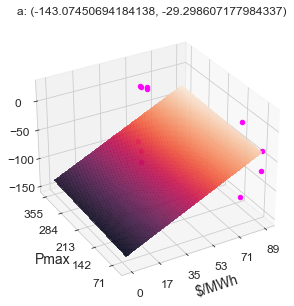

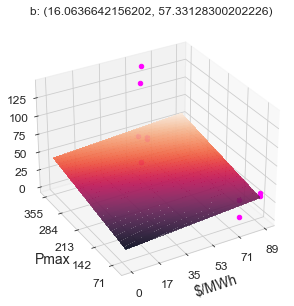

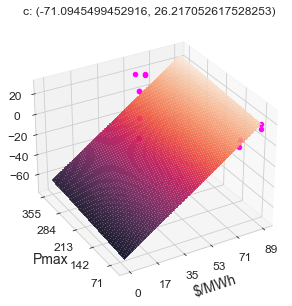

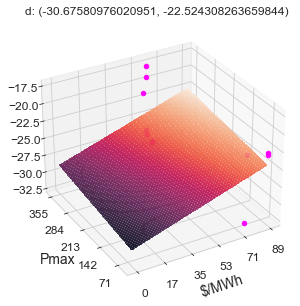

In [ ]:
def func_lin(x, a_0, a_1, a_2):
    pmax = x[0]
    hr_avg = x[1]
    return a_1 * pmax + a_2 * hr_avg + a_0

xdata0 = (fit_df['HR_avg'].values / fit_df['HR_avg'].max())
xdata1 = (fit_df['PMax MW'].values / fit_df['PMax MW'].max())
xdata = np.array(list(zip(xdata0, xdata1))).T


for param in ("a", "b", "c", "d"):
    ydata = (fit_df[param].values)
    popt, pcov = curve_fit(func_lin, xdata, ydata)
    print(popt)

    @np.vectorize
    def fit_a(x, y):
        return func_lin([x, y], *popt)
        
    hr = np.linspace(0, fit_df["HR_avg"].max(), 200) / fit_df['HR_avg'].max()
    pmax = np.linspace(fit_df['PMax MW'].min(), fit_df['PMax MW'].max(), 200) / fit_df['PMax MW'].max()

    fig = plt.figure(figsize=(12, 5))
    # sharex=True, sharey=True, projection='3d')
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    X, Y = np.meshgrid(hr, pmax)

    for x, y, z in zip(xdata0, xdata1, ydata):
        ax.scatter(x, y, z, marker='o', color='magenta')

    Z = fit_a(X, Y)
    g = ax.contourf(X, Y, Z, 200, alpha=0.7)
    ax.set_xlabel("$/MWh")
    ax.set_ylabel("Pmax")
    ax.set_title(f"{param}: ({np.min(Z)}, {np.max(Z)})")

    xticks = np.array(ax.get_xticks() * fit_df['HR_avg'].max() * 3.88722 * 1e-3, dtype='int')
    ax.set_xticklabels(xticks)
    ax.set_yticklabels(np.array(ax.get_yticks() * fit_df['PMax MW'].max(), dtype='int'))
    ax.view_init(elev=ax.elev, azim=60+180)


### Get average shape and then translate up or down as average translation per generator

Text(0, 0.5, '$/MWh')

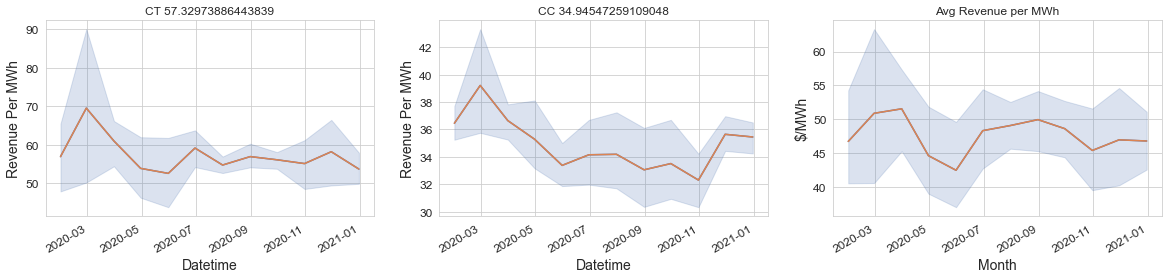

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 4), sharex=True)
sns.lineplot(data=gen_monthly[gen_monthly['Type'] == "CT"], x='Datetime', y='Revenue Per MWh', ax=axs[0])
avg_revenue_per_mwh = gen_monthly[gen_monthly['Type'] == "CT"].groupby("Datetime").mean()['Revenue Per MWh']
avg_revenue_per_mwh.plot(title="CT "+str(avg_revenue_per_mwh.mean()), ax=axs[0])

sns.lineplot(data=gen_monthly[gen_monthly['Type'] == "CC"], x='Datetime', y='Revenue Per MWh', ax=axs[1])
avg_revenue_per_mwh = gen_monthly[gen_monthly['Type'] == "CC"].groupby("Datetime").mean()['Revenue Per MWh']
avg_revenue_per_mwh.plot(title="CC "+str(avg_revenue_per_mwh.mean()), ax=axs[1])

sns.lineplot(data=gen_monthly, x='Datetime', y='Revenue Per MWh', ax=axs[2])
avg_revenue_per_mwh = gen_monthly.groupby("Datetime").mean()['Revenue Per MWh']
avg_revenue_per_mwh.plot(title="Both "+str(avg_revenue_per_mwh.mean()), ax=axs[2])
avg_revenue_per_mwh.values

axs[2].set_xlabel("Month")
axs[2].set_title("Avg Revenue per MWh")
axs[2].set_ylabel("$/MWh")

In [ ]:
fit_df_copy = fit_df.copy()

In [ ]:
for gen in fit_df.Generator.unique():
    fit_df.loc[fit_df['Generator'] == gen, 'Avg Revenue Per MWh'] = gen_monthly[gen_monthly['Generator'] == gen]['Revenue Per MWh'].mean()
    fit_df.loc[fit_df['Generator'] == gen, 'Delta Avg Revenue Per MWh'] = gen_monthly[gen_monthly['Generator'] == gen]['Revenue Per MWh'].mean() - avg_revenue_per_mwh.mean()
    
fit_df = fit_df.dropna(axis=0)
fit_df

,Generator,Bus ID,Gen ID,Unit Group,Unit Type,Category,Fuel,MW Inj,MVAR Inj,V Setpoint p.u.,PMax MW,PMin MW,QMax MVAR,QMin MVAR,Min Down Time Hr,Min Up Time Hr,Ramp Rate MW/Min,Start Time Cold Hr,Start Time Warm Hr,Start Time Hot Hr,Start Heat Cold MBTU,Start Heat Warm MBTU,Start Heat Hot MBTU,Non Fuel Start Cost $,Non Fuel Shutdown Cost $,FOR,MTTF Hr,MTTR Hr,Scheduled Maint Weeks,Fuel Price $/MMBTU,Output_pct_0,Output_pct_1,Output_pct_2,Output_pct_3,HR_avg_0,HR_incr_1,HR_incr_2,HR_incr_3,VOM,Fuel Sulfur Content %,Emissions SO2 Lbs/MMBTU,Emissions NOX Lbs/MMBTU,Emissions Part Lbs/MMBTU,Emissions CO2 Lbs/MMBTU,Emissions CH4 Lbs/MMBTU,Emissions N2O Lbs/MMBTU,Emissions CO Lbs/MMBTU,Emissions VOCs Lbs/MMBTU,Damping Ratio,Inertia MJ/MW,Base MVA,Transformer X p.u.,Unit X p.u.,Pump Load MW,Storage Roundtrip Efficiency,HR_avg_1,HR_avg_2,HR_avg_3,HR_avg,a,b,c,d,Avg Revenue Per MWh,Delta Avg Revenue Per MWh
8,107_CC_1,107,1,U355,CC,Gas CC,NG,355.00,49.51,1.0500,355.0,170,150,-25,4.5,8.0,4.14,2,1.00,0.50,7215.1,4536.1,3196.6,0,0,0.033,967,33,1.07,3.88722,0.478873,0.652582,0.826291,1.0,7222.0,5970.0,6892.0,7854.0,0.0,0,0.0006,0.079999998,0,118,0.0,0.0,0.0,0.0,0,5.0,414.0,0.13,0.30,0,0,13192.0,20084.0,21046.0,15386.00,-11.227190,2.478113,1.484518,-19.292648,33.411482,-14.170443
17,118_CC_1,118,1,U355,CC,Gas CC,NG,355.00,68.43,1.0500,355.0,170,150,-25,4.5,8.0,4.14,2,1.00,0.50,7215.1,4536.1,3196.6,0,0,0.033,967,33,1.07,3.88722,0.478873,0.652582,0.826291,1.0,7257.0,5808.0,7140.0,8351.0,0.0,0,0.0006,0.079999998,0,118,0.0,0.0,0.0,0.0,0,5.0,414.0,0.13,0.30,0,0,13065.0,20205.0,21416.0,15485.75,-148.079274,139.085799,-45.438397,-27.743430,32.452778,-15.129147
39,221_CC_1,221,1,U355,CC,Gas CC,NG,296.97,-7.52,1.0500,355.0,170,150,-25,4.5,8.0,4.14,2,1.00,0.50,7215.1,4536.1,3196.6,0,0,0.033,967,33,1.07,3.88722,0.478873,0.652582,0.826291,1.0,6887.0,5950.0,6772.0,9293.0,0.0,0,0.0006,0.079999998,0,118,0.0,0.0,0.0,0.0,0,5.0,414.0,0.13,0.30,0,0,12837.0,19609.0,22130.0,15365.75,-126.299134,115.978275,-25.358539,-27.007324,32.722420,-14.859505
54,307_CT_1,307,1,U55,CT,Gas CT,NG,55.00,19.00,0.9568,55.0,22,19,-15,2.2,2.2,3.70,1,0.75,0.25,1457.4,1122.5,452.8,0,0,0.031,969,31,0.79,3.88722,0.400000,0.600000,0.800000,1.0,13353.0,7176.0,7517.0,9126.0,0.0,0,0.0006,0.079999998,0,118,0.0,0.0,0.0,0.0,0,2.8,64.0,0.13,0.32,0,0,20529.0,28046.0,29655.0,22895.75,-68.904825,35.080488,19.002610,-22.797800,64.846629,17.264704
55,307_CT_2,307,2,U55,CT,Gas CT,NG,55.00,19.00,0.9568,55.0,22,19,-15,2.2,2.2,3.70,1,0.75,0.25,1457.4,1122.5,452.8,0,0,0.031,969,31,0.79,3.88722,0.400000,0.600000,0.800000,1.0,13353.0,7176.0,7517.0,9126.0,0.0,0,0.0006,0.079999998,0,118,0.0,0.0,0.0,0.0,0,2.8,64.0,0.13,0.32,0,0,20529.0,28046.0,29655.0,22895.75,-34.952861,30.589041,13.988068,-23.041507,64.808493,17.226568
56,313_CC_1,313,1,U355,CC,Gas CC,NG,355.00,150.00,1.0350,355.0,170,150,-25,4.5,8.0,4.14,2,1.00,0.50,7215.1,4536.1,3196.6,0,0,0.033,967,33,1.07,3.88722,0.478873,0.652582,0.826291,1.0,7934.0,4047.0,6883.0,8683.0,0.0,0,0.0006,0.079999998,0,118,0.0,0.0,0.0,0.0,0,5.0,414.0,0.13,0.30,0,0,11981.0,18864.0,20664.0,14860.75,-107.279279,42.165923,19.345530,-21.444744,35.504083,-12.077842
63,315_CT_7,315,7,U55,CT,Gas CT,NG,55.00,19.00,1.0422,55.0,22,19,-15,2.2,2.2,3.70,1,0.75,0.25,1457.4,1122.5,452.8,0,0,0.031,969,31,0.79,3.88722,0.400000,0.600000,0.800000,1.0,10342.0,6792.0,6919.0,8195.0,0.0,0,0.0006,0.079999998,0,118,0.0,0.0,0.0,0.0,0,2.8,64.0,0.13,0.32,0,0,17134.0,24053.0,25329.0,19214.50,-101.863517,34.278582,9.981989,-22.236026,50.244482,2.662557
64,315_CT_8,315,8,U55,CT,Gas CT,NG,55.00,60.00,1.0422,55.0,22,60,0,2.2,2.2,3.70,1,0.75,0.25,1457.4,1122.5,452.8,0,0,0.031,969,31,0.79,3.88722,0.400000,0.600000,0.800000,1.0,10342.0,6792.0,6919.0,8195.0,0.0,0,0.0006,0.079999998,0,118,0.0,0.0,0.0,0.0,0,2.8,64.0,0.13,0.32,0,0,17134.0,24053.0,25329.0,19214.50,23.286394,10.770458,3.234927,-32.028985,46.493745,-1.088180
67,321_CC_1,321,1,U355,CC,Gas CC,NG,355.00,-3.34,1.0500,355.0,170,150,-25,4.5,8.0,4.14,2,1.00

In [ ]:
fit_df[['Avg Revenue Per MWh', 'Delta Avg Revenue Per MWh']]

,Avg Revenue Per MWh,Delta Avg Revenue Per MWh
8,33.411482,-14.170443
17,32.452778,-15.129147
39,32.722420,-14.859505
54,64.846629,17.264704
55,64.808493,17.226568
56,35.504083,-12.077842
63,50.244482,2.662557
64,46.493745,-1.088180
67,34.125036,-13.456889
70,34.508374,-13.073551


In [ ]:
input_cols = [
      #  'MW Inj',
       'PMax MW',
       'HR_avg_0', 
      #  'HR_incr_1', 
      #  'HR_incr_2', 
      #  'HR_incr_3'
       ]
 
X = fit_df[input_cols].to_numpy()
y = fit_df['Delta Avg Revenue Per MWh'].to_numpy()

regtree = DecisionTreeRegressor(random_state=1)
regtree.fit(X, y)

poly = PolynomialFeatures(degree=1)
X_poly = poly.fit_transform(X)
regpoly = LinearRegression()
regpoly.fit(X_poly, y)

display(regtree.score(X, y), regpoly.score(X_poly,y))
display(sorted(list(zip(regpoly.coef_, input_cols)), key=lambda r: -r[0])[0:10])
display(regpoly.intercept_)

0.9955689031579343

0.9916150065046819

[(0.00437471013199738, 'HR_avg_0'), (0.0, 'PMax MW')]

-54.08860665863774

<AxesSubplot:xlabel='HR_incr_2', ylabel='Delta Avg Revenue Per MWh'>

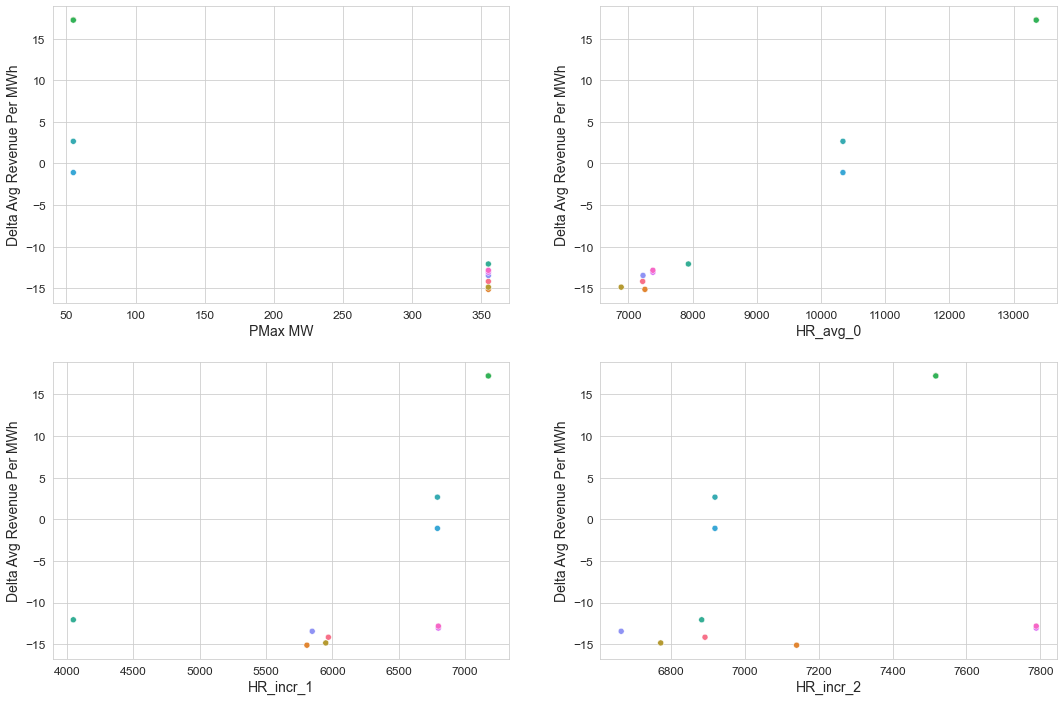

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(18, 12))
sns.scatterplot(ax=ax[0, 0],
    data=fit_df, y="Delta Avg Revenue Per MWh", x="PMax MW", hue="Generator", legend=False
)
sns.scatterplot(ax=ax[0, 1],
    data=fit_df, y="Delta Avg Revenue Per MWh", x="HR_avg_0", hue="Generator", legend=False
)
sns.scatterplot(ax=ax[1, 0],
    data=fit_df, y="Delta Avg Revenue Per MWh", x="HR_incr_1", hue="Generator", legend=False
)
sns.scatterplot(ax=ax[1, 1],
    data=fit_df, y="Delta Avg Revenue Per MWh", x="HR_incr_2", hue="Generator", legend=False
)

### Fit NN

In [ ]:
%%script false --no-raise-error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Min Up Time Hr as state of charge required?
column_names = ['PMax MW', 'HR_avg_0', "Min Up Time Hr"]
column_names = ['PMax MW', 'PMin MW',
       'QMax MVAR', 'QMin MVAR', 'Min Down Time Hr', 'Min Up Time Hr',
       'Ramp Rate MW/Min', 'Start Time Cold Hr', 'Start Time Warm Hr',
       'Start Time Hot Hr', 'Start Heat Cold MBTU', 'Start Heat Warm MBTU',
       'Start Heat Hot MBTU', 'Output_pct_0',
       'Output_pct_1', 'Output_pct_2', 'Output_pct_3', 'Output_pct_4',
       'HR_avg_0', 'HR_incr_1', 'HR_incr_2', 'HR_incr_3', 'HR_incr_4', ]
column_names = ['PMax MW']
train_features = ng_df.copy()
train_features["Month"] = train_features.set_index("Datetime").index.month

for c in column_names:
    train_features[c] = -1
for gen in train_features['Generator'].unique():
    bid = bid_df[bid_df['Generator'] == gen]
    # for c in column_names:
        # train_features.loc[(ng_df['Generator'] == gen), c] = bid[c].unique()[0]

train_features = train_features.drop(columns=["Datetime", 'Generator', "Unit Market Revenue", 'Unit Uplift Payment', "Dispatch", 'Dispatch DA', 'Headroom', 'Unit Cost', 'Type'])
train_features = train_features.dropna(axis=1)
train_labels = train_features.pop('CF')

input_layer = layers.Input(train_features.shape[1:])

normalizer = layers.Normalization(input_shape=[9,], axis=None)
normalizer.adapt(train_features)
normalizer = normalizer(input_layer)

output_a = layers.Dense(1, activation='sigmoid')(normalizer)

output_b = layers.Dense(1)(normalizer) # This will be one of my outputs, so I want a linear activation

final_output = layers.Add()([output_a, output_b])
model = tf.keras.Model(input_layer, final_output)

def my_loss_fn(y_true, y_pred):
    # squared_difference = tf.square(y_true - y_pred)
    loss = abs(y_true - y_pred)
    # return tf.reduce_mean(squared_difference, axis=-1) 
    return tf.reduce_mean(loss, axis=-1) 

model.compile(loss=my_loss_fn,
                optimizer=tf.keras.optimizers.Adam(0.001))
display(model.summary())

history = model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()